# The Inverted Pendulum (or the Cart-Pole System)

In this notebook, we will go through implementing the inverted pendulum system for which we'll train a neural network to learn to control the pendulum state.

We will train a separate network to learn the system dynamics as well. 

A part of this exercise will also show you how to make animations in matplotlib!

In [1]:
import warnings
import torch
import numpy as np
from matplotlib import animation
from IPython.display import HTML

import neuralode
import copy
import itertools
import matplotlib.pyplot as plt

warnings.simplefilter('ignore', RuntimeWarning)
warnings.simplefilter('ignore', UserWarning)

In [2]:
# For convenience, we define the default tensor device and dtype here
torch.set_default_device('cpu')
# In neural networks, we prefer 32-bit/16-bit floats, but for precise integration, 64-bit is preferred. We will revisit this later when we need to mix integration with neural network training
torch.set_default_dtype(torch.float64)

In [3]:
mass_cart   = torch.tensor(1.0)  # kg
mass_pole   = torch.tensor(0.1)  # kg
length_pole = torch.tensor(1.0)  # m
gravity     = torch.tensor(9.81) # m/s^2
friction_cart = torch.tensor(0.0)
friction_pole = torch.tensor(0.0)

def inverted_pendulum(state, time, force, mc, mp, l, g, mu_c, mu_p):
    theta, theta_dot, x, x_dot = state[...,0], state[...,1], state[...,2], state[...,3]
    
    dtheta = theta_dot
    dx = x_dot
    
    stheta, ctheta = theta.sin(), theta.cos()
    
    theta_dot_sq = theta_dot.square()
    total_mass = mc + mp*stheta.square()
    
    if torch.all(mu_c == 0.0) and torch.all(mu_p == 0.0):
        pole_moment_of_inertia = mp * l/2
        counter_force = (force + pole_moment_of_inertia * stheta * theta_dot_sq)
        dtheta_dot = stheta * g - ctheta * counter_force / total_mass
        dtheta_dot = dtheta_dot * 2/l / (4.0/3.0 - mp * ctheta.square() / total_mass)
        dx_dot = (counter_force - pole_moment_of_inertia * ctheta * dtheta_dot)
        dx_dot = dx_dot / total_mass
    else:
        sgn_xdot = torch.sign(x_dot)
        paren1_pre = -force - mp * l/2 * theta_dot_sq * (stheta + mu_c * ctheta * sgn_xdot) + mu_c * g * sgn_xdot
        
        dtheta_dot_common = g * stheta - (mu_p / mp) * x_dot * 2/l
        dtheta_dot = dtheta_dot_common + ctheta * paren1_pre 
        dtheta_dot = dtheta_dot * 2/l / (4.0/3.0 - mp * ctheta / total_mass * (ctheta - mu_c * sgn_xdot))
        
        Nc = total_mass * g - mp * l/2 * (dtheta_dot * stheta + theta_dot_sq * ctheta)
        
        corr_needed = (torch.sign(Nc) < 0) & (mu_c > 0.0)
        sgn_Ncxdot = torch.sign(Nc*x_dot)
        paren1_post = -force - mp * l/2 * theta_dot_sq * (stheta + mu_c * ctheta * sgn_Ncxdot) + mu_c * g * sgn_Ncxdot
            
        dtheta_dot_pre = dtheta_dot_common + ctheta * paren1_post
        dtheta_dot = torch.where(corr_needed, dtheta_dot_pre * 2/l / (4.0/3.0 - mp*ctheta/total_mass * (ctheta - mu_c * sgn_Ncxdot)), dtheta_dot)
    
        Nc = torch.where(corr_needed, (mc + mp) * g - mp * l/2 * (dtheta_dot * stheta + theta_dot_sq * ctheta), Nc)
            
        dx_dot = (force + mp * (theta_dot_sq * stheta - dtheta_dot * ctheta) - mu_c * Nc * torch.sign(Nc * x_dot))/(mc + mp)
    
    return torch.stack([
        dtheta,
        dtheta_dot,
        dx,
        dx_dot
        ], dim=-1)

In [4]:
initial_state = torch.tensor([0.0,0.01,0.0,0.0])

initial_time = torch.tensor(0.0)
final_time   = torch.tensor(5.0)

initial_timestep = torch.tensor(5e-2)

current_integrator = neuralode.integrators.AdaptiveRK76Integrator

atol, rtol = torch.tensor(0.0), torch.tensor(1e-8)

In [5]:
final_state, _, sha_states, sha_times, _ = current_integrator.apply(inverted_pendulum, initial_state, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, torch.tensor(0.0), mass_cart, mass_pole, length_pole, gravity, friction_cart, friction_pole)

In [6]:
def plot_pendulum(pendulum_x, pendulum_y, cart_x, cart_y):
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.scatter(pendulum_x[0].item(), pendulum_y[0].item(), marker='o')
    ax.scatter(pendulum_x[-1].item(), pendulum_y[-1].item(), marker='x')
    ax.plot(pendulum_x.cpu().numpy(), pendulum_y.cpu().numpy())
    ax.plot(cart_x.cpu().numpy(), cart_y.cpu().numpy())
    for cx, cy, wx, wy in zip(cart_x, cart_y, pendulum_x, pendulum_y):
        ax.plot([cx.item(), wx.item()], [cy.item(), wy.item()], linewidth=0.25, linestyle='--', color='k')
    ax.scatter(cart_x[0].item(), 0.0, marker='o')
    ax.scatter(cart_x[-1].item(), 0.0, marker='x')
    ax.axhline(cart_y.mean(), linewidth=0.5, color='k')
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2, 2)
    return fig, ax

def animate_pendulum(pendulum_x, pendulum_y, cart_x, cart_y, system_times, frame_time=1000/60):
    plt.ioff()
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')

    t_initial, t_final = system_times.min().item(), system_times.max().item()
    frame_times = np.linspace(t_initial, t_final, int(1000*(t_final - t_initial)/frame_time+0.5))

    pendulum_x = np.interp(frame_times, system_times.cpu().numpy(), pendulum_x.cpu().numpy())
    pendulum_y = np.interp(frame_times, system_times.cpu().numpy(), pendulum_y.cpu().numpy())
    cart_x = np.interp(frame_times, system_times.cpu().numpy(), cart_x.cpu().numpy())
    cart_y = np.interp(frame_times, system_times.cpu().numpy(), cart_y.cpu().numpy())
    
    pole_plot, = ax.plot([cart_x[0], pendulum_x[0].item()], [cart_y[0], pendulum_y[0]], linewidth=0.25, linestyle='--', color='k')
    pendulum_head_plot, = ax.plot(pendulum_x[0], pendulum_y[0], marker='o')
    cart_plot, = ax.plot(cart_x[0], cart_y[0], marker='o')
    ax.axhline(cart_y.mean(), linewidth=0.5, color='k')
    
    def animate(frame_index):
        pole_plot.set_data([cart_x[frame_index], pendulum_x[frame_index]], [cart_y[frame_index], pendulum_y[frame_index].item()])
        pendulum_head_plot.set_data([pendulum_x[frame_index]], [pendulum_y[frame_index]])
        cart_plot.set_data([cart_x[frame_index]], [cart_y[frame_index]])
        
    ani = animation.FuncAnimation(fig, animate, frames=cart_x.shape[0], interval=frame_time)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2, 2)
    html_ani = ani.to_html5_video()

    plt.close(fig)
    plt.ion()
    return html_ani

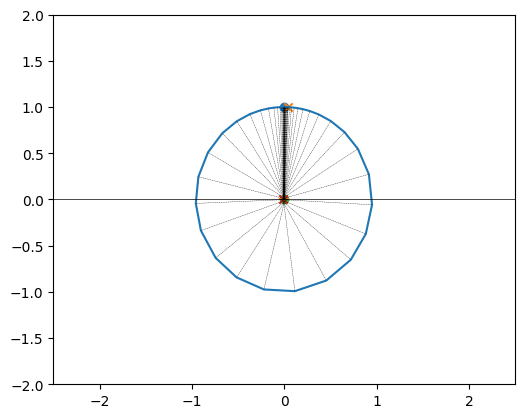

In [7]:
pendulum_x = torch.sin(sha_states[...,0]) * length_pole + sha_states[...,2]
pendulum_y = torch.cos(sha_states[...,0]) * length_pole

cart_x, cart_y = sha_states[...,2], torch.zeros_like(sha_states[...,2])

plot_pendulum(pendulum_x, pendulum_y, cart_x, cart_y);

In [8]:
HTML(animate_pendulum(pendulum_x, pendulum_y, cart_x, cart_y, sha_times, frame_time=1000/60))

In [9]:
max_force = torch.tensor(80.0)

# we define our network as a subclass of torch.nn.Module
# This allows PyTorch to appropriately track parameters
class CartPoleNet(torch.nn.Module):
    def __init__(self, num_hidden_neurons=8, num_hidden_layers=2):
        # First we initialise the superclass, `torch.nn.Module`
        super().__init__()
        # Then we define the actual neural network
        # Most Neural Networks operate sequentially so they can be wrapped
        # inside a torch.nn.Sequential which takes each layer
        # as an argument.
        # Since we're only learning one matrix, we have
        # one layer, the `torch.nn.Linear`.
        # `torch.nn.Linear` stores a matrix and a bias which actually makes it
        # an Affine transformation rather than a purely linear transformation
        hidden_layers = itertools.chain.from_iterable([(torch.nn.Linear(num_hidden_neurons, num_hidden_neurons), torch.nn.ReLU()) for _ in range(num_hidden_layers)])
        
        self.internal_net = torch.nn.Sequential(
            torch.nn.Linear(6, num_hidden_neurons),
            torch.nn.ReLU(),
            *hidden_layers,
            torch.nn.Linear(num_hidden_neurons, 1, bias=False),
        )
    
    def forward(self, x, t):
        # Our network only depends on x, but since it could also depend on t, we have
        # included it for completeness
        # Additionally, PyTorch layers and modules expect a batched tensor
        # ie. a tensor where the first dimension is over different samples
        # Since we don't depend on batches, we check if the input is 1-dimensional
        # And add a batch dimension as needed for the internal module
        cos_angle, sin_angle = torch.cos(x[...,0]), torch.sin(x[...,0])
        encoded_state = torch.stack(
            [cos_angle, sin_angle, -x[...,1]*sin_angle, x[...,1]*cos_angle, x[...,2], x[...,3]],
        dim=-1)
        if x.dim() == 1:
            return self.internal_net(encoded_state[None])[0]*max_force
        else:
            return self.internal_net(encoded_state)*max_force
        
cart_pole_net = CartPoleNet()
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight, gain=0.5)
        if m.bias is not None:
            torch.nn.init.normal_(m.bias, std=0.1)

cart_pole_net.apply(init_weights)

def nn_controlled_pendulum(state, time, mc, mp, l, g, mu_c, mu_p, *args):
    force = cart_pole_net(state, time)[...,0]
    return inverted_pendulum(state, time, force, mc, mp, l, g, mu_c, mu_p)

In [10]:
# As the goal is balancing the pole on top of the cart, we generate several initial states where the pole
# is near vertical and moving with some random rotational velocity. This way, the neural network observes
# multiple states near the vertical state where it needs to learn to counter-balance it.

state_min = torch.tensor([-torch.pi*1e-1, -1e-2*torch.pi/(final_time - initial_time), 0.0, 0.0])
state_max = torch.tensor([ torch.pi*1e-1,  1e-2*torch.pi/(final_time - initial_time), 0.0, 0.0])
state_dataset = torch.rand(127, 4) * (state_max - state_min)[None] + state_min[None]
# # Additionally, we want to include the state where the pendulum is hanging below the cart so that the network
# # can learn how to swing the pendulum back over the cart
state_dataset = torch.cat([state_dataset, initial_state[None]], dim=0)

def batched_integrator(x0):
    return current_integrator.apply(nn_controlled_pendulum, x0, initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, mass_cart, mass_pole, length_pole, gravity, friction_cart, friction_pole, *cart_pole_net.parameters())

# First, we'll create an `optimiser` following pytorch convention
optimiser = torch.optim.Adam(cart_pole_net.parameters(), lr=1e-3, amsgrad=True)
# # Whenever the loss plateaus, we can reduce the learning rate to improve convergence
lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, patience=10)

def pendulum_closure(minibatch):
    optimiser.zero_grad()
    
    states = minibatch['states']
    
    final_state, _, intermediate_states, intermediate_times, _ = batched_integrator(states)

    error = final_state.square().mean() + 1e-2*(intermediate_states[1:].square().sum(dim=-1) * intermediate_times.detach().diff(dim=-1)[:,None]).sum(dim=0).mean()
    
    if error.requires_grad:
        error.backward()
    return error

# We need to set the size of our mini-batches
batch_size = 16

# Now we need an optimisation `loop` where we will take steps to minimise the error
number_of_gd_steps = 1024

In [11]:
class PID(torch.nn.Module):
    def __init__(self, target_state, p, i, d):
        super().__init__()
        self.target_state = torch.nn.Parameter(torch.as_tensor(target_state), requires_grad=False)
        self.p = torch.nn.Parameter(torch.as_tensor(p))
        self.i = torch.nn.Parameter(torch.as_tensor(i))
        self.d = torch.nn.Parameter(torch.as_tensor(d))
        self.integral = torch.tensor(0.0)
        self.derivative = torch.tensor(0.0)
        self.prev_error = torch.tensor(0.0)
        
    def forward(self, state):
        error = state - self.target_state
        self.integral = self.integral + error.detach()
        self.derivative = error.detach() - self.prev_error
        self.prev_error = error.detach()
        pid = (self.p * error + self.i * self.integral + self.d * self.derivative)[...,0]
        
        return torch.sigmoid(pid)*max_force

pid_controller = PID(torch.tensor([0.0,0.0,0.0,0.0]), 0.1, 0.01, 0.5)

def pid_controlled_pendulum(state, time, mc, mp, l, g, mu_c, mu_p, *args):
    force = pid_controller(state)
    return inverted_pendulum(state, time, force, mc, mp, l, g, mu_c, mu_p)

In [12]:
best_error = torch.inf
best_params = copy.deepcopy(cart_pole_net.state_dict())

cart_pole_net.train()

for step in range(number_of_gd_steps):
    epoch_error = 0.0
    shuffled_indices = torch.randperm(state_dataset.shape[0])
    for batch_idx in range(0, state_dataset.shape[0], batch_size):
        batch_dict = {
            'states': state_dataset[shuffled_indices][batch_idx:batch_idx+batch_size],
        }
    
        step_error = optimiser.step(lambda: pendulum_closure(batch_dict))
        epoch_error = epoch_error + step_error.item()*batch_dict['states'].shape[0]
        print(f"[{step+1}/{number_of_gd_steps}]/[{batch_idx}/{state_dataset.shape[0]}] Batch Error: {step_error:.6f}", end='\r')
    epoch_error = epoch_error/state_dataset.shape[0]
    if epoch_error < best_error:
        best_error = epoch_error
        best_params = copy.deepcopy(cart_pole_net.state_dict())
    lr_on_plateau.step(epoch_error)
    print(" "*128, end="\r")
    print(f"[{step+1}/{number_of_gd_steps} - {lr_on_plateau.get_last_lr()[0]}] Epoch Error: {epoch_error:.6f}")
    # If the step size is too small, then we can interrupt the
    # training as it will not lead to significant improvements
    if lr_on_plateau.get_last_lr()[0] < 1e-6:
        break

[1/1024 - 0.001] Epoch Error: 1100.098564                                                                                       


KeyboardInterrupt: 

In [13]:
cart_pole_net.load_state_dict(best_params)
cart_pole_net.eval()

final_state, _, sha_states, sha_times, _ = current_integrator.apply(nn_controlled_pendulum, state_dataset[10], initial_time, final_time, initial_timestep, {'atol': atol, 'rtol': rtol}, mass_cart, mass_pole, length_pole, gravity, friction_cart, friction_pole)

cart_pole_net(sha_states, sha_times)

tensor([[3.9546],
        [3.9610],
        [3.9630],
        [3.9640],
        [3.9546],
        [3.9404],
        [3.9266],
        [3.9118],
        [3.8980],
        [3.8773],
        [3.8463],
        [3.8000],
        [3.7309],
        [3.6279],
        [3.5583],
        [3.5431],
        [3.5326],
        [3.5169],
        [3.4931],
        [3.4898],
        [3.4759],
        [3.4590],
        [3.4336],
        [3.3958],
        [3.3394],
        [3.3154],
        [3.2845],
        [3.2407],
        [3.1754],
        [3.1491],
        [3.1186],
        [3.0895],
        [3.0461],
        [2.9816],
        [2.8862],
        [2.7460],
        [2.5424],
        [2.4965],
        [2.4657],
        [2.4373],
        [2.3952],
        [2.3334],
        [2.2440],
        [2.1187],
        [1.9580],
        [1.8133],
        [1.8031],
        [1.8068],
        [1.8353],
        [1.9354],
        [2.2461],
        [3.0340],
        [3.5065],
        [3.8642],
        [3.9585],
        [4

(<Figure size 640x480 with 1 Axes>, <Axes: >)

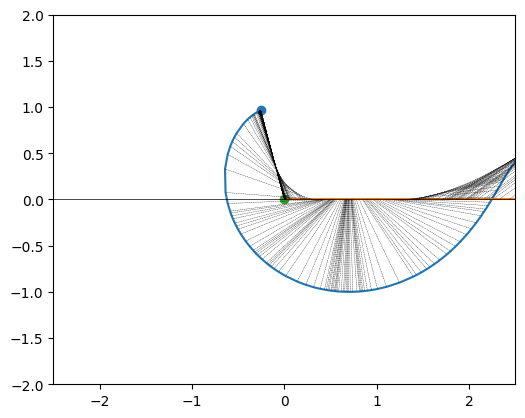

In [14]:
cart_x = sha_states[...,2]
cart_y = torch.zeros_like(cart_x)

pendulum_x = torch.sin(sha_states[...,0]) * length_pole + cart_x
pendulum_y = torch.cos(sha_states[...,0]) * length_pole
plot_pendulum(pendulum_x, pendulum_y, cart_x, cart_y)

In [15]:
HTML(animate_pendulum(pendulum_x, pendulum_y, cart_x, cart_y, sha_times, frame_time=1000/60))